## Table of Contents
- [Table of Contents](#table-of-contents)
- [1) Environment & Imports](#environment-imports)
- [2) Experiment Configuration](#experiment-configuration)
- [3) Decide Clip Length (Optional)](#decide-clip-length-optional)
- [4) Create Experiment Layout](#create-experiment-layout)
- [5) Prepare Dataset (Load / Split / Save Originals)](#prepare-dataset-load-split-save-originals)
- [6) Prepare Models](#prepare-models)
- [7) Sanity Checks](#sanity-checks)
- [8) Train & Evaluate (Optional)](#train-evaluate-optional)
- [9) Metrics & Plots (Optional)](#metrics-plots-optional)
- [Appendix — Tips & Troubleshooting](#appendix-tips-troubleshooting) 

<a id="basic-example"></a>
# Basic Example

This notebook prepares data from the ZIPs (`real.zip`, `fake.zip`), loads **benchmark** models from torchvision (VGG, ResNet, ALEXNET) according to your configuration, and trains for **3 epochs** per transformation.

**Prerequisites**:
- Notebook folder: `notebooks/`
- ZIPs in `../dataset/` (at the repo root): `real.zip`, `fake.zip`
- (Optional) user-provided TorchScript models in `../models/`


In [3]:

import sys, os
from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path.insert(0, lib_path)
print("Project root added to sys.path:", lib_path)


Project root added to sys.path: D:\FakeVoiceFinder


<a id="environment-imports"></a>
## 1) Environment & Imports
<a id='sec1'></a>

**Goal:** Make sure the environment has the required packages and import the project modules.

**Requirements:**
- Python 3.9+ (recommended)
- `numpy`, `pandas`, `matplotlib`
- `librosa`, `soundfile`, `PyWavelets`
- `scikit-learn`, `torch`, `torchvision`

**Install (example):**
```bash
pip install numpy pandas matplotlib librosa soundfile PyWavelets scikit-learn torch torchvision
```
Run the next cell(s) to import `ExperimentConfig`, `CreateExperiment`, and helpers.

In [5]:
# 2) Imports principales
from pprint import pprint
from fakevoicefinder import ExperimentConfig, CreateExperiment, ModelLoader, Trainer, ConfigError,shortest_audio_seconds


<a id="experiment-configuration"></a>
## 2) Experiment Configuration
<a id='sec2'></a>

**Goal:** Define models, transforms, and hyperparameters.

**Key fields in `ExperimentConfig`:**
- `models_list`: e.g., `['alexnet', 'resnet18', 'convnext_tiny']`
- `transform_list`: any of `['mel', 'log', 'dwt']`
- `mel_params`, `log_params`, `dwt_params`: optional **overrides** (dicts). Defaults are used if not set.
- `clip_seconds`: window length (seconds) for each audio (pad/trim). Default is 3.0 s.
- `image_size`: **optional** resize for MEL/LOG (e.g., `224` for ViT).

Tip: Keep defaults first; only override if you need a different setting.

In [7]:
from fakevoicefinder import ExperimentConfig, ConfigError

cfg = ExperimentConfig()

# Experiment name (folder under outputs/)
cfg.run_name = "exp_all_v1"

# Paths (repo-relative)
cfg.data_path = "../dataset"   # where real.zip and fake.zip are
cfg.models_path = "../models"  # user TorchScript models

# Transforms to generate
cfg.transform_list = ["mel","dwt","log","cqt"]   # now we use MEL + CQT

# --- mel: valid keys ---
# n_mels, n_fft, hop_length, win_length, fmin, fmax
cfg.mel_params = {
    "n_mels": 68,
    "n_fft": 2048,
    "hop_length": 512,
    # "win_length": None,
    # "fmin": 0,
    # "fmax": None,
}

# --- log: valid keys ---
# n_fft, hop_length, win_length
cfg.log_params = {
    "n_fft": 2048,
    "hop_length": 256,
    # "win_length": None,
}

# --- dwt: valid keys ---
# wavelet, level, mode
cfg.dwt_params = {
    "wavelet": "db6",
    "level": 5,
    "mode": "symmetric",
}

# --- cqt: valid keys ---
# hop_length, n_bins, bins_per_octave, fmin, scale
cfg.cqt_params = {
    "hop_length": 256,      # good time–frequency tradeoff
    "n_bins": 96,           # recommended range ~84–120
    "bins_per_octave": 24,  # 12 or 24 → 24 gives more detail on formants
    "scale": True,          # more stable spectral distribution
    # "fmin": 32.70319566,  # C1 (this is the default in the code)
    # "fmin": 65.40639133,  # C2 if you want to shift focus to vocal range
}

cfg.image_size = 224

# Benchmark models to test
cfg.models_list = [
        "alexnet",
        "resnet18",
        "resnet34",
        "resnet50",
        "vgg16",
        "vgg19",
        "densenet121",
        "mobilenet_v2",
        "efficientnet_b0",
        "squeezenet1_0",
        "vit_b_16",
        "googlenet",
        "inception_v3",
        "convnext_tiny",
        "convnext_small",
        "convnext_base"
]

# Quick smoke-test training
cfg.type_train = "both"   # 'scratch' | 'pretrain' | 'both'
cfg.epochs = 10
cfg.batch_size = 8
cfg.learning_rate = 0.0001
cfg.patience = 5

# Input channels for spectrograms (.npy): 1 channel
cfg.input_channels = 1 

# Config validation
try:
    cfg.validate()
    print("Config validation ✅")
except ConfigError as e:
    print("Config validation error:", e)
    raise

print(cfg.summary())



Config validation ✅
ExperimentConfig:
  batch_size     : 8
  cache_features : True
  clip_seconds   : None
  cqt_params     : {'hop_length': 256, 'n_bins': 96, 'bins_per_octave': 24, 'scale': True}
  data_path      : ../dataset
  device         : gpu
  dwt_params     : {'wavelet': 'db6', 'level': 5, 'mode': 'symmetric'}
  epochs         : 10
  eval_metric    : ['accuracy', 'F1']
  fake_zip       : fake.zip
  flag_train     : True
  image_size     : 224
  input_channels : 1
  learning_rate  : 0.0001
  log_params     : {'n_fft': 2048, 'hop_length': 256}
  mel_params     : {'n_mels': 68, 'n_fft': 2048, 'hop_length': 512}
  models_list    : ['alexnet', 'resnet18', 'resnet34', 'resnet50', 'vgg16', 'vgg19', 'densenet121', 'mobilenet_v2', 'efficientnet_b0', 'squeezenet1_0', 'vit_b_16', 'googlenet', 'inception_v3', 'convnext_tiny', 'convnext_small', 'convnext_base']
  models_path    : ../models
  num_workers    : 4
  optimizer      : Adam
  outputs_path   : outputs
  patience       : 5
  real_

<a id="decide-clip-length-optional"></a>
## 3) Decide Clip Length (Optional)
<a id='sec3'></a>

**Goal:** Choose the time window (`clip_seconds`) to use for all audios.

Use `shortest_audio_seconds(cfg)` to scan `reals.zip` and `fakes.zip` and return the shortest duration in seconds. Then either:
- **A)** set `cfg.clip_seconds = min_duration` to avoid truncation; or
- **B)** choose a fixed value (e.g., 3.0 s). Short files will be **zero-padded** automatically.

In [9]:
# Select the audio window (clip_seconds)
min_sec = int(shortest_audio_seconds(cfg))
print(f"Duración mínima detectada en los zips: {min_sec}")

# Option A: use exactly the minimum detected
cfg.clip_seconds = min_sec

# Option B: use a fixed value of your choice (e.g., 3.0 s)
# cfg.clip_seconds = 3.0

# Note: if you set a value greater than many audio files, it will be filled with padding (as the pipeline already does).


Duración mínima detectada en los zips: 4


<a id="create-experiment-layout"></a>
## 4) Create Experiment Layout
<a id='sec4'></a>

**Goal:** Initialize the experiment folder structure and manifest (`experiment.json`).

Run `CreateExperiment(cfg).build()` to set up:
- `outputs/<RUN>/datasets/{train,test}/...`
- `outputs/<RUN>/models/loaded/`
- `outputs/<RUN>/reports/`

The manifest stores paths and metadata for reproducibility.

In [11]:
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)
exp.build()

{'models': {'alexnet': {'loaded_path': None,
   'trained_path': None,
   'train_parameters': {'epochs': 10,
    'learning_rate': 0.0001,
    'batch_size': 8,
    'optimizer': 'Adam',
    'patience': 5,
    'device': 'gpu',
    'seed': 23,
    'type_train': 'both',
    'num_workers': 4,
    'transform': None}},
  'resnet18': {'loaded_path': None,
   'trained_path': None,
   'train_parameters': {'epochs': 10,
    'learning_rate': 0.0001,
    'batch_size': 8,
    'optimizer': 'Adam',
    'patience': 5,
    'device': 'gpu',
    'seed': 23,
    'type_train': 'both',
    'num_workers': 4,
    'transform': None}},
  'resnet34': {'loaded_path': None,
   'trained_path': None,
   'train_parameters': {'epochs': 10,
    'learning_rate': 0.0001,
    'batch_size': 8,
    'optimizer': 'Adam',
    'patience': 5,
    'device': 'gpu',
    'seed': 23,
    'type_train': 'both',
    'num_workers': 4,
    'transform': None}},
  'resnet50': {'loaded_path': None,
   'trained_path': None,
   'train_parameters'

<a id="prepare-dataset-load-split-save-originals"></a>
## 5) Prepare Dataset (Load / Split / Save Originals / Transform)
<a id='sec5'></a>

**Goal:**
1) Read `real.zip` and `fake.zip`.
2) Stratified split into train/validation.
3) Extract original audio files into the experiment folders.
4) Generate Transforms (MEL / LOG / DWT / CQT)

In [13]:
summary = exp.prepare_data(train_ratio=0.8, seed=cfg.seed, transforms=cfg.transform_list)
print("Data prep summary:")
pprint(summary)

print("Manifest:", (exp.root / "experiment.json").as_posix())

Data prep summary:
{'load': {'fake': 600, 'real': 600},
 'save_original': {'test': 240, 'train': 960},
 'split': {'test': {'fake': 120, 'real': 120, 'total': 240},
           'train': {'fake': 480, 'real': 480, 'total': 960}},
 'transforms': {'cqt': {'test': 240, 'train': 960},
                'dwt': {'test': 240, 'train': 960},
                'log': {'test': 240, 'train': 960},
                'mel': {'test': 240, 'train': 960}}}
Manifest: D:/FakeVoiceFinder/outputs/exp_all_v1/experiment.json


<a id="prepare-models"></a>
## 6) Prepare Models

In [15]:
loader = ModelLoader(exp)
bench = loader.prepare_benchmarks(add_softmax=False, input_channels=getattr(cfg, "input_channels", 1))
print("Benchmarks saved under models/loaded:")
pprint(bench)

# User models (if any .pt/.pth under cfg.models_path)
user = loader.prepare_user_models(add_softmax=False, input_channels=cfg.input_channels)
print("User models saved:")
pprint(user)

C:\Users\Gpach\anaconda3\envs\environmenttestfake\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\Gpach\anaconda3\envs\environmenttestfake\Lib\site-packages\torchvision\models\googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(
C:\Users\Gpach\anaconda3\envs\environmenttestfake\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Benchmarks saved under models/loaded:
{'alexnet': {'pretrain': 'outputs/exp_all_v1/models/loaded/alexnet_pretrain.pt',
             'scratch': 'outputs/exp_all_v1/models/loaded/alexnet_scratch.pt'},
 'convnext_base': {'pretrain': 'outputs/exp_all_v1/models/loaded/convnext_base_pretrain.pt',
                   'scratch': 'outputs/exp_all_v1/models/loaded/convnext_base_scratch.pt'},
 'convnext_small': {'pretrain': 'outputs/exp_all_v1/models/loaded/convnext_small_pretrain.pt',
                    'scratch': 'outputs/exp_all_v1/models/loaded/convnext_small_scratch.pt'},
 'convnext_tiny': {'pretrain': 'outputs/exp_all_v1/models/loaded/convnext_tiny_pretrain.pt',
                   'scratch': 'outputs/exp_all_v1/models/loaded/convnext_tiny_scratch.pt'},
 'densenet121': {'pretrain': 'outputs/exp_all_v1/models/loaded/densenet121_pretrain.pt',
                 'scratch': 'outputs/exp_all_v1/models/loaded/densenet121_scratch.pt'},
 'efficientnet_b0': {'pretrain': 'outputs/exp_all_v1/models/loade

In [16]:
print(exp.loaded_models)
print(exp.loaded_models.exists())

D:\FakeVoiceFinder\outputs\exp_all_v1\models\loaded
True


In [17]:
cfg.models_path

'../models'

<a id="sanity-checks"></a>
## 7) Sanity Checks
<a id='sec7'></a>

**Goal:** Verify shapes and parameters saved to the manifest.

- Load one `.npy` per class and print its shape.
- Inspect `experiment.json` parameters under `train_data.transforms_dataset[<name>].params`.

In [19]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 cqt
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 cqt
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 convnext_base_pretrain.pt
      📄 convnext_base_scratch.pt
      📄 convnext_small_pretrain.pt
      📄 convnext_small_scratch.pt
      📄 convnext_tiny_pretrain.pt
      📄 convnext_tiny_scratch.pt
      📄 densenet121_pretrain.pt
      📄 densenet121_scratch.pt
      📄 efficientnet_b0_pretrain.pt
      📄 efficientnet_b0_scratch.pt
      📄 googlenet_pretrain.pt
      📄 googlenet_scratch.pt
      📄 inception_v3_pretrain.pt
      📄 inception_v3_scratch.pt
      📄 mobilenet_v2_pretrain.pt
      📄 mobilenet_v2_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 resnet34_pretrain.pt
      📄 resnet34_scratch

<a id="train-evaluate-optional"></a>
## 8) Train & Evaluate (Optional)
<a id='sec8'></a>

**Goal:** Train your selected models and compute metrics on the test split.

- Use your training loop or the provided trainer to fit each model.
- Evaluate with `MetricsReporter` to build a DataFrame of scores (Accuracy, F1).

In [21]:
exp.loaded_models

WindowsPath('D:/FakeVoiceFinder/outputs/exp_all_v1/models/loaded')

In [22]:
trainer = Trainer(exp)
train_results = trainer.train_all()
print("Training results (repo-relative paths):")
pprint(train_results)

print("Best checkpoints stored in:", (exp.trained_models).as_posix())


[Trainer] Using device: cuda
[Trainer] Transforms to train: ['mel', 'dwt', 'log', 'cqt']
[Trainer] Models found: ['alexnet', 'resnet18', 'resnet34', 'resnet50', 'vgg16', 'vgg19', 'densenet121', 'mobilenet_v2', 'efficientnet_b0', 'squeezenet1_0', 'vit_b_16', 'googlenet', 'inception_v3', 'convnext_tiny', 'convnext_small', 'convnext_base', 'usermodel_SimpleCNN_scripted.pt']

=== MODEL: alexnet ===
[alexnet] Hyperparams -> epochs=10, lr=0.0001, bs=8, optimizer=Adam, patience=5, seed=23, num_workers=4
[alexnet][mel] Dataset sizes -> train: 1920, test: 480
[alexnet][mel] Batches -> train: 240, test: 60
[alexnet][mel][scratch] Loading checkpoint: D:\FakeVoiceFinder\outputs\exp_all_v1\models\loaded\alexnet_scratch.pt
[alexnet][mel][scratch] Loaded pickled module.
[alexnet][mel][scratch] Start training for 10 epochs
[alexnet][mel][scratch] Epoch 1/10 - loss=0.6923 acc=0.5000
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 240, FP=   0],
 [FN= 240, TP=   0]]
[alexnet][mel][scratch] ✅ New 

In [23]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 cqt
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 cqt
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 convnext_base_pretrain.pt
      📄 convnext_base_scratch.pt
      📄 convnext_small_pretrain.pt
      📄 convnext_small_scratch.pt
      📄 convnext_tiny_pretrain.pt
      📄 convnext_tiny_scratch.pt
      📄 densenet121_pretrain.pt
      📄 densenet121_scratch.pt
      📄 efficientnet_b0_pretrain.pt
      📄 efficientnet_b0_scratch.pt
      📄 googlenet_pretrain.pt
      📄 googlenet_scratch.pt
      📄 inception_v3_pretrain.pt
      📄 inception_v3_scratch.pt
      📄 mobilenet_v2_pretrain.pt
      📄 mobilenet_v2_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 resnet34_pretrain.pt
      📄 resnet34_scratch

<a id="metrics-plots-optional"></a>
## 9) Metrics & Plots (Optional)
<a id='sec9'></a>

**Goal:** Visualize results.

- `plot_architectures_for_transform`: bar chart of `(model+variant)` for a single transform.
- `plot_variants_for_model`: bar chart of `(transform)` for a single `(model, variant)`.
- `plot_heatmap_models_transforms`: heatmap over `(models×variants) × transforms`.

**Color map defaults:** worst value → red, better → green, max at 100%. Each cell shows its value in %.

In [25]:
from fakevoicefinder.config import ExperimentConfig
from fakevoicefinder.experiment import CreateExperiment
from fakevoicefinder.metrics import MetricsReporter

EXP_NAME = cfg.run_name  

cfg = ExperimentConfig(); cfg.run_name = EXP_NAME
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)  

rep = MetricsReporter(exp)                   # toma reports/ del manifest
df = rep.evaluate_all("metrics_summary.csv") # guarda CSV en outputs/<exp>/reports/

[metrics] CSV saved -> D:\FakeVoiceFinder\outputs\exp_all_v1\reports\metrics_summary.csv


In [26]:
df

,model,variant,transform,accuracy,f1,f1_macro,f1_micro,precision,recall,checkpoint
0,alexnet,pretrain,cqt,92.50,91.96,92.47,92.50,99.04,85.83,outputs/exp_all_v1/models/trained/alexnet_pret...
1,alexnet,scratch,cqt,94.17,94.31,94.16,94.17,92.06,96.67,outputs/exp_all_v1/models/trained/alexnet_scra...
2,convnext_base,pretrain,cqt,97.92,97.94,97.92,97.92,96.75,99.17,outputs/exp_all_v1/models/trained/convnext_bas...
3,convnext_base,scratch,cqt,78.75,79.35,78.73,78.75,77.17,81.67,outputs/exp_all_v1/models/trained/convnext_bas...
4,convnext_small,pretrain,cqt,93.75,93.39,93.73,93.75,99.07,88.33,outputs/exp_all_v1/models/trained/convnext_sma...
...,...,...,...,...,...,...,...,...,...,...
127,vgg16,scratch,mel,94.17,94.12,94.17,94.17,94.92,93.33,outputs/exp_all_v1/models/trained/vgg16_scratc...
128,vgg19,pretrain,mel,96.67,96.64,96.67,96.67,97.46,95.83,outputs/exp_all_v1/models/trained/vgg19_pretra...
129,vgg19,scratch,mel,50.00,33.33,33.33,50.00,0.00,0.00,outputs/exp_all_v1/models/trained/vgg19_scratc...
130,vit_b_16,pretrain,mel,50.00,33.33,33.33,50.00,0.00,0.00,outputs/exp_all_v1/models/trained/vit_b_16_pre...


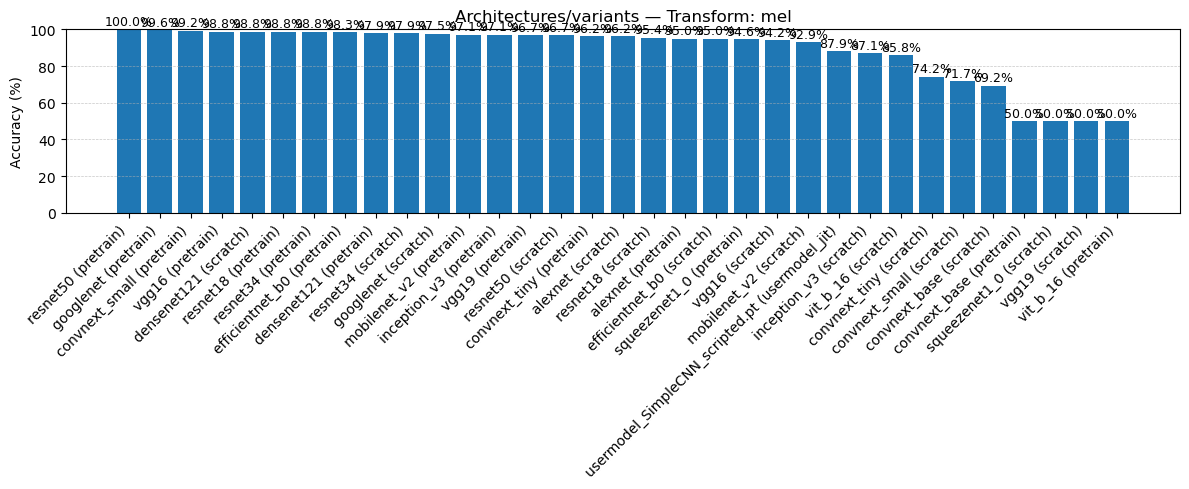

[metrics] Figure saved -> D:\FakeVoiceFinder\outputs\exp_all_v1\reports\fig_arch_mel_acc.png


In [27]:
# Figuras (se guardan en 'reports/' al pasar out_name)
rep.plot_architectures_for_transform(df, transform="mel", metric="accuracy",
                                     y_min=0, y_max=100, out_name="fig_arch_mel_acc.png")


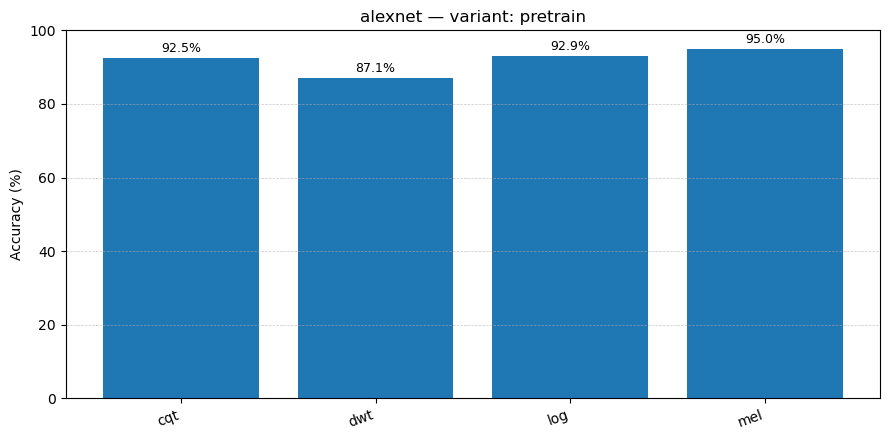

[metrics] Figure saved -> D:\FakeVoiceFinder\outputs\exp_all_v1\reports\fig_alexnet_pretrain_accuracy.png


In [28]:
rep.plot_variants_for_model(df, model="alexnet", variant="pretrain", metric="accuracy",
                              y_min=0, y_max=100, out_name="fig_alexnet_pretrain_accuracy.png")


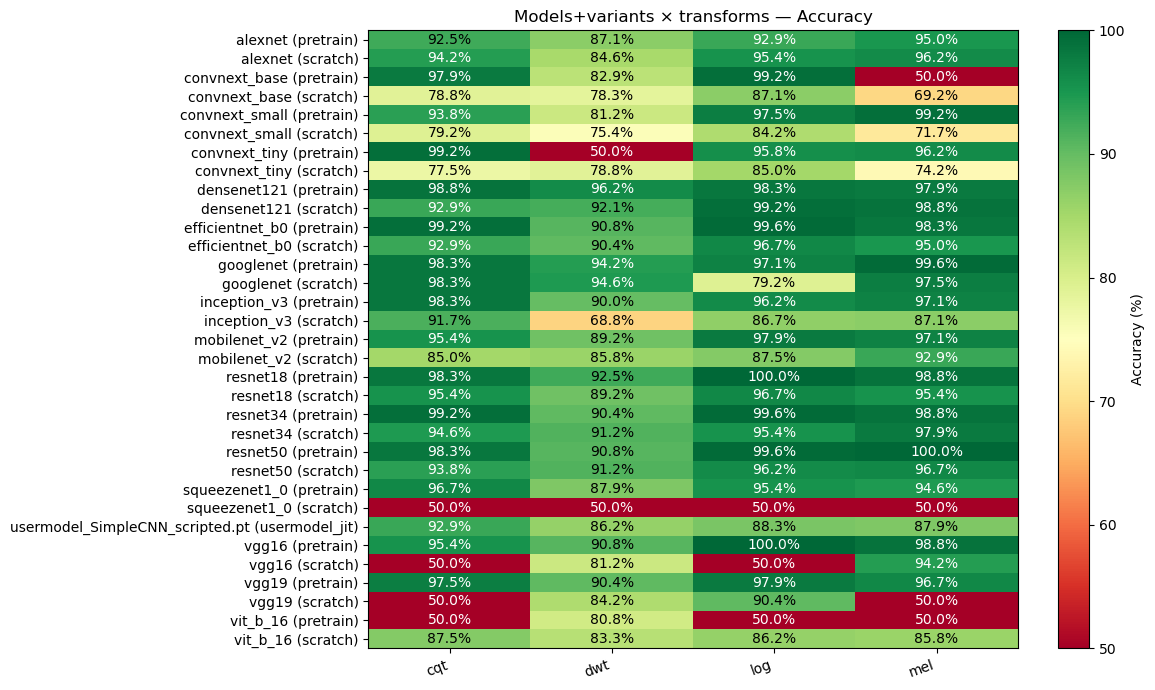

[metrics] Figure saved -> D:\FakeVoiceFinder\outputs\exp_all_v1\reports\fig_all.png


In [29]:
rep.plot_heatmap_models_transforms(df, metric="accuracy", vmin=50, vmax=100,
                                   out_name="fig_all.png")


<a id="appendix-tips-troubleshooting"></a>
## Appendix — Tips & Troubleshooting
<a id='sec10'></a>

- If using ViT/ConvNeXt, prefer **224×224** inputs. Set `cfg.image_size = 224` (MEL/LOG) or use **DWT**.
- If audio files vary in length, pick an appropriate `clip_seconds`. Shorter files are zero-padded.
- If you change transform hyperparameters, rerun the transform step to regenerate features.
- Ensure CUDA is available if `cfg.device='gpu'`. Otherwise, it will fall back to CPU.
- Check `outputs/<RUN>/reports/` for figures and CSVs.